In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from tensorflow.keras.models import Sequential

In [2]:
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
data_dir = 'data/dataset/'
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31476 files belonging to 126 classes.
Using 22034 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 31476 files belonging to 126 classes.
Using 9442 files for validation.


In [6]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

NameError: name 'mal_font' is not defined

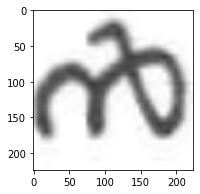

In [7]:
image_batch, label_batch = train_ds.as_numpy_iterator().next()
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(label_batch[i], fontproperties=mal_font)
    plt.axis("off")

In [8]:
class_names = train_ds.class_names


In [9]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = len(class_names)
IMG_SHAPE = (img_width, img_height, 3)

## InceptionNet


In [12]:

basemodel = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
basemodel.trainable = False
basemodel.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = basemodel(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [14]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

In [15]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = basemodel(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs,name = 'inception_model')
model.summary()

Model: "inception_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 126)           

In [16]:
lr = 0.001
b1 = 0.9
b2 = 0.999 
ep = 1e-07
EPOCHS = 8

In [17]:
checkpoint_filepath = 'models/checkpoints/inceptionnet/model'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1,beta_2=b2, epsilon=ep, decay=0.0),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [19]:

history = model.fit(
  train_ds,
  validation_data=val_ds,
      callbacks=[model_checkpoint_callback],
  epochs=EPOCHS
)

Epoch 1/8
689/689 [==============================] - 76s 105ms/step - loss: 1.6080 - accuracy: 0.6184 - val_loss: 0.7629 - val_accuracy: 0.8099
Epoch 2/8
689/689 [==============================] - 101s 147ms/step - loss: 0.5468 - accuracy: 0.8634 - val_loss: 0.5161 - val_accuracy: 0.8633
Epoch 3/8
689/689 [==============================] - 119s 173ms/step - loss: 0.3362 - accuracy: 0.9194 - val_loss: 0.4156 - val_accuracy: 0.8884
Epoch 4/8
689/689 [==============================] - 97s 141ms/step - loss: 0.2313 - accuracy: 0.9483 - val_loss: 0.3516 - val_accuracy: 0.9027
Epoch 5/8
689/689 [==============================] - 116s 168ms/step - loss: 0.1713 - accuracy: 0.9655 - val_loss: 0.3222 - val_accuracy: 0.9059
Epoch 6/8
689/689 [==============================] - 122s 178ms/step - loss: 0.1321 - accuracy: 0.9744 - val_loss: 0.2900 - val_accuracy: 0.9142
Epoch 7/8
689/689 [==============================] - 92s 133ms/step - loss: 0.1062 - accuracy: 0.9799 - val_loss: 0.2916 - val_accur

In [20]:
loss_p, accuracy = model.evaluate(test_dataset)
accuracy = accuracy * 100
print(f"Loss: {loss_p:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

59/59 [==============================] - 5s 81ms/step - loss: 0.3014 - accuracy: 0.9211
Loss: 0.30%
Accuracy: 92.11%


In [21]:
import datetime
today = datetime.datetime.now()
folder_name = f'{today.hour}-{today.minute}_{today.day:02d}-{today.month}-{today.year}'
path = os.path.join('results','model_summary','inceptionnet',folder_name)
if not os.path.exists(path):
    os.makedirs(path)
model_folder = path

In [22]:
import pickle
pickle.dump(history.history, open(model_folder+'\history.pickle', 'wb'))

In [23]:
# save as directory
model.save(model_folder+f'\model')

INFO:tensorflow:Assets written to: results\model_summary\inceptionnet\11-0_24-3-2022\model\assets


In [24]:
# save weights
model.save_weights(model_folder+f'/model_{num_classes}_inceptionnet_acc{int(accuracy)}.h5')

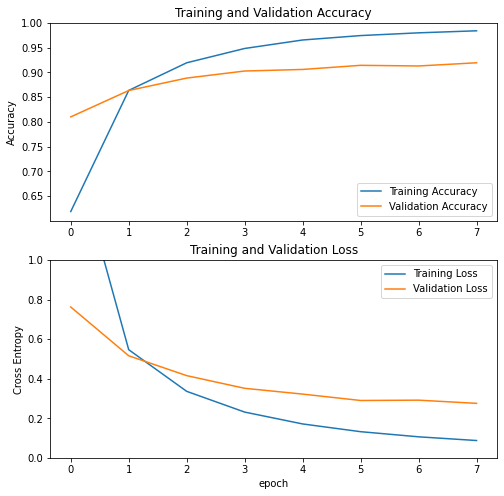

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(model_folder+'\combined.png')
plt.show()

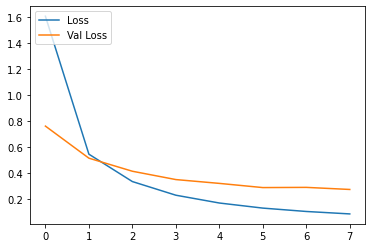

In [26]:
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val Loss")
plt.legend(loc="upper left")
plt.savefig(model_folder+'\loss.png')
plt.show()

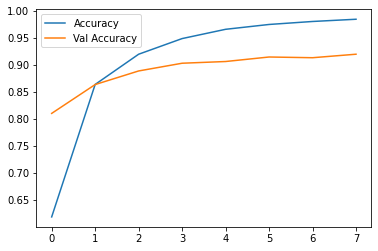

In [27]:
plt.plot(history.history['accuracy'],label="Accuracy")
plt.plot(history.history['val_accuracy'],label="Val Accuracy")
plt.legend(loc="upper left")
plt.savefig(model_folder+'\\accuracy.png')
plt.show()

### Fine tuning

In [28]:
# backup 
og_model = model

In [29]:
print("Number of layers in the base model: ", len(basemodel.layers))

Number of layers in the base model:  311


In [30]:
basemodel.trainable = True 

In [31]:
# Fine-tune from this layer onwards
fine_tune_at = 150

# Freeze all the layers before the `fine_tune_at` layer
for layer in basemodel.layers[:fine_tune_at]:
  layer.trainable =  False

In [32]:
lr = 1e-05
b1 = 0.9
b2 = 0.999 
ep = 1e-07

In [33]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=b1,beta_2=b2, epsilon=ep, decay=0.0),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [34]:
model.summary()

Model: "inception_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 126)           

In [35]:
fine_tune_epochs = 4
total_epochs =  EPOCHS + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                        callbacks=[model_checkpoint_callback],
                         validation_data=val_ds)

Epoch 8/12
689/689 [==============================] - 168s 233ms/step - loss: 0.0521 - accuracy: 0.9848 - val_loss: 0.1411 - val_accuracy: 0.9579
Epoch 9/12
689/689 [==============================] - 158s 229ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.1122 - val_accuracy: 0.9661
Epoch 10/12
689/689 [==============================] - 138s 200ms/step - loss: 0.0149 - accuracy: 0.9956 - val_loss: 0.1020 - val_accuracy: 0.9711
Epoch 11/12
689/689 [==============================] - 153s 222ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.0982 - val_accuracy: 0.9718
Epoch 12/12
689/689 [==============================] - 151s 220ms/step - loss: 0.0103 - accuracy: 0.9969 - val_loss: 0.0717 - val_accuracy: 0.9801


In [36]:
model.load_weights(checkpoint_filepath)

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

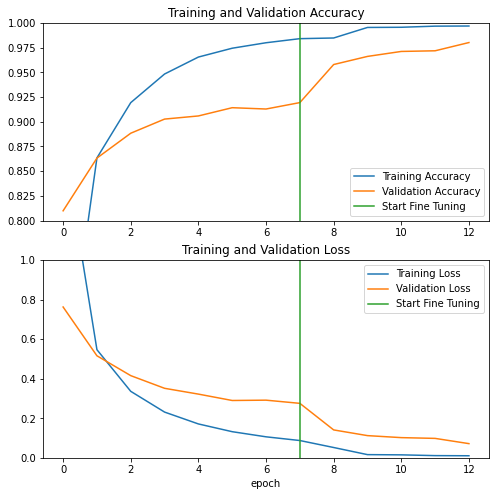

In [38]:

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(model_folder+'\combined-finetuned.png')
plt.show()

In [39]:
loss_finetuned, accuracy_finetuned = model.evaluate(test_dataset)
accuracy_finetuned = accuracy_finetuned * 100
print('Test accuracy :', accuracy_finetuned)

59/59 [==============================] - 5s 79ms/step - loss: 0.0851 - accuracy: 0.9772
Test accuracy : 97.7224588394165


In [40]:
def predict_word(num):
    pred = ''
    ch = class_names[num]
    lis = ch.split(' ')
    char_list = [chr(int(i)) for i in lis]
    pred += ''.join(char_list)
    return pred

In [41]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [42]:
predictions

array([[2.6151847e-14, 5.4539488e-20, 1.2273045e-12, ..., 1.4916586e-12,
        2.4848694e-17, 6.4671799e-17],
       [2.5905652e-17, 9.6681532e-21, 4.2579734e-18, ..., 4.9854133e-17,
        7.6766821e-17, 3.1006868e-19],
       [1.8133169e-16, 2.3092440e-19, 3.0443793e-15, ..., 4.0649828e-22,
        3.2951874e-16, 2.6909006e-16],
       ...,
       [5.7458199e-13, 1.1541759e-18, 1.2177246e-16, ..., 1.2515399e-14,
        3.7369032e-16, 4.4530798e-16],
       [1.1834259e-18, 4.3451894e-17, 1.3107349e-15, ..., 2.9304796e-20,
        2.4456023e-14, 1.2896277e-13],
       [4.1277957e-15, 4.5185306e-21, 3.0805036e-19, ..., 3.4255479e-16,
        5.4330460e-13, 2.8671684e-16]], dtype=float32)

In [43]:
from matplotlib.font_manager import FontProperties
from pathlib import Path
# point to the font location with an absolute path
nirm = Path('c:/Windows/Fonts/kartika.ttf')

# configure the Hindi font
mal_font = FontProperties(fname=nirm)

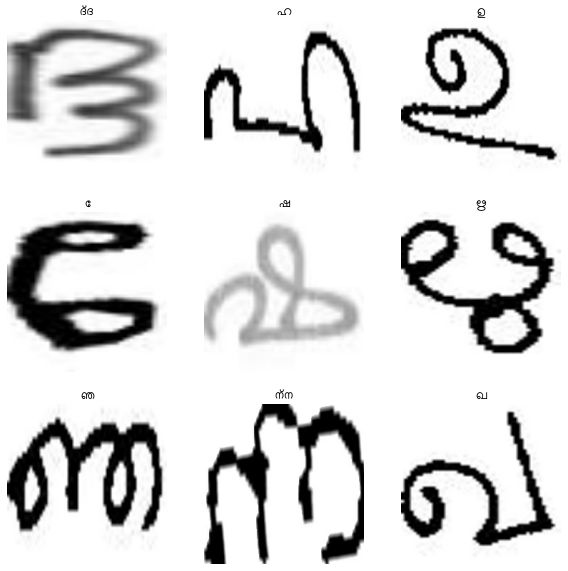

In [44]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    pred_word = predict_word(predictions[i].argmax(axis=-1))
    plt.title(pred_word, fontproperties=mal_font)
    plt.axis("off")

In [45]:
# save weights
model.save_weights(model_folder+f'/model_{num_classes}_inceptionnet_finetuned-acc{int(accuracy)}.h5')

In [46]:
# save as directory
model.save(model_folder+f'\model_finetuned')

INFO:tensorflow:Assets written to: results\model_summary\inceptionnet\11-0_24-3-2022\model_finetuned\assets


In [47]:
classes = np.array(class_names)

In [48]:
with open(model_folder+'\class_names.npy', 'wb') as f:
    np.save(f, classes)

In [49]:
pickle.dump(history_fine.history, open(model_folder+'\history_fine.pickle', 'wb'))

In [50]:
f = open(model_folder+"\\config.txt", "w")
f.writelines([f'Batch" {batch_size}\nLR: {lr}\n',f'Beta 1:{b1}\n',f'Beta 2:{b2}\n',f'Classes: {num_classes}',f'epsilon:{ep}\n',f'epochs:{EPOCHS}\n',f'accuracy: {accuracy}\n',f'accuracy finetuned: {accuracy_finetuned}\n'])
f.close()